In [1]:
from google.colab import files
uploaded = files.upload()

Saving data.txt to data.txt
Saving stop_words.txt to stop_words.txt


In [2]:
import os
os.listdir('./')

['.config', 'stop_words.txt', 'data.txt', 'sample_data']

In [3]:
#################### CPU – jedno vláknový algoritmus ###########################
print("CPU – jedno vláknový algoritmus")
print("===============================")
from collections import Counter
import time
from math import ceil
import numpy as np
import re

def apply_filter(words, stop_words):
  filtered = []
  for word in words:
    if len(word) >= 4 and len(word) <= 8 and word not in stop_words:
      filtered.append(word)
  return filtered

with open('data.txt') as f:
    words=[word for line in f for word in line.split()]
with open('stop_words.txt') as f2:
    stop_words = [word for line in f2 for word in line.split()]
#lower-case words to increase match
words = [word.lower() for word in words]
stop_words = [word.lower() for word in stop_words]
#remove special char
for idx,word in enumerate(words):
  words[idx] = re.sub('\W+','', word)
words = list(filter(None, words))

start = time.time_ns()

filtered = apply_filter(words, stop_words)
counter = Counter(filtered)

stop = time.time_ns()
most1 = counter.most_common(1)[0]
least1 = counter.most_common()[:-1-1:-1][0]
total1 = len(filtered)


duration1 = round(stop-start, 3)
print("nejfrekventovanější slovo a počet jeho výskytů: '",most1[0],"':",most1[1])
print("nejméně frekventované slovo a počet jeho výskytů: '",least1[0],"':",least1[1])
print("celkový počet slov po filtracích: ",total1)
print("CPU čas: {0} ms".format(duration1/1000000))

CPU – jedno vláknový algoritmus
nejfrekventovanější slovo a počet jeho výskytů: ' that ': 2955
nejméně frekventované slovo a počet jeho výskytů: ' includes ': 1
celkový počet slov po filtracích:  107366
CPU čas: 60.823087 ms


In [4]:
################## CPU – více-vláknový algoritmus ##############################
print("\nCPU – více-vláknový algoritmus")
print("===============================")
import multiprocessing as mp
from collections import Counter
import time
from math import ceil
import numpy as np
import re

def apply_filter(words, stop_words):
  filtered = []
  for word in words:
    if len(word) >= 4 and len(word) <= 8 and word not in stop_words:
      filtered.append(word)
  return filtered

# print("Number of processors: ", mp.cpu_count())

with open('data.txt') as f:
    words=[word for line in f for word in line.split()]
with open('stop_words.txt') as f2:
    stop_words = [word for line in f2 for word in line.split()]

#lower-case words to increase match
words = [word.lower() for word in words]
stop_words = [word.lower() for word in stop_words]

#remove special char
for idx,word in enumerate(words):
  words[idx] = re.sub('\W+','', word)
words = list(filter(None, words))

n_cores = mp.cpu_count()
filtered = []
chunked_list = []
chunk_size = ceil(len(words)/n_cores)

for i in range(0, len(words), chunk_size):
    chunked_list.append((words[i:i+chunk_size], stop_words))

start = time.time_ns()

with mp.Pool() as pool:
        filtered_chunks = pool.starmap(apply_filter, chunked_list)
        pool.close()
        pool.join()

for chunk in filtered_chunks:
  filtered.extend(chunk)

counter = Counter(filtered)

stop = time.time_ns()

most2 = counter.most_common(1)[0]
least2 = counter.most_common()[:-1-1:-1][0]
total2 = len(filtered)


duration2 = round(stop-start, 3)
print("nejfrekventovanější slovo a počet jeho výskytů: '",most2[0],"':",most2[1])
print("nejméně frekventované slovo a počet jeho výskytů: '",least2[0],"':",least2[1])
print("celkový počet slov po filtracích: ",total2)
print("CPU čas: {0} ms".format(duration2/1000000))


CPU – více-vláknový algoritmus
nejfrekventovanější slovo a počet jeho výskytů: ' that ': 2955
nejméně frekventované slovo a počet jeho výskytů: ' includes ': 1
celkový počet slov po filtracích:  107366
CPU čas: 202.348671 ms


In [5]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 29.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 71 kB 10.9 MB/s 
  Created wheel for pycuda: filename=pycuda-2022.2-cp38-cp38-linux_x86_64.whl size=646470 sha256=cc8aa2203b043eacaded9787aa5c83a31cb2edf1cddf7047f99e7880c5d3e960
  Stored in directory: /root/.cache/pip/wheels/ef/0e/11/809b20ee6df2e1c63ef52b3dcf2b7386b900d4f58548f0484e
  Created wheel for pytools: filename=pytools-2022.1.13-py2.py3-none-any.whl size=66024 sha256=27ae645af7d4e23918e873cd20be641c41dfcc341a3389e7abbd9bdc8ca8250e
  Stored in directory: /root/.cache/pip/wheels/b5/c1/bb/26ba70fb9d10f195249ef4e170a92ae83e7534e55b67786fd9
Successfully built pycuda pytools


In [6]:
############################### GPU verze ######################################
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
from collections import Counter
import numpy as np
import time
import re

cuda.init()
dev = cuda.Device(0)
ctx = dev.make_context()

with open('data.txt') as f:
    words=[word for line in f for word in line.split()]
with open('stop_words.txt') as f2:
    stop_words =[word for line in f2 for word in line.split()]

words = [word.lower() for word in words]
stop_words = [word.lower() for word in stop_words]
#remove special char
for idx,word in enumerate(words):
  words[idx] = re.sub('\W+','', word)
words = list(filter(None, words))

words = list(filter(lambda x: len(x) >= 4 and len(x) <= 8,words))
stop_words = list(filter(lambda x: len(x) >= 4 and len(x) <= 8,stop_words))
dictionary = dict([(y,x+1) for x,y in enumerate(set(words))])

words_vect = []
for word in words:
  words_vect.append(dictionary.get(word))

stop_words_vect = []
for word in stop_words:
  stop_words_vect.append(dictionary.get(word))

BLOCK_SIZE = 256
N_STOP_WORDS = len(stop_words_vect)
gridDim = int(len(words_vect)/BLOCK_SIZE + 1)

words = np.array(words_vect).astype(np.int32)
stop_words = np.array(stop_words_vect).astype(np.int32)
filtered = np.zeros(len(words)).astype(np.int32)
counted = np.zeros(len(words)).astype(np.int32)

words_gpu = cuda.mem_alloc(words.nbytes)
stop_words_gpu = cuda.mem_alloc(stop_words.nbytes)
filtered_gpu = cuda.mem_alloc(filtered.nbytes)
counted_gpu = cuda.mem_alloc(counted.nbytes)

cuda.memcpy_htod(words_gpu, words)
cuda.memcpy_htod(stop_words_gpu, stop_words)

kernel_code = """
  __global__ void apply_filter(int *words, int *stop_words, int *output, const int N) {
    
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    
    __shared__ int words_shared[BLOCK_SIZE];
    __shared__ int stop_words_shared[N_STOP_WORDS];

    if (idx < N) {
      if (threadIdx.x < N_STOP_WORDS) {
        stop_words_shared[threadIdx.x] = stop_words[threadIdx.x];
      }
      words_shared[threadIdx.x] = words[idx];

      __syncthreads();
      
      for (int i = 0; i < N_STOP_WORDS; i++) {
        if (words_shared[threadIdx.x] != stop_words_shared[i]) {
          output[idx] = words_shared[threadIdx.x];
        } else {
          output[idx] = 0;
          break;
        }
      }
    }
  }

  __global__ void count_stats(int *words, int *output, const int N) {

    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    __shared__ int words_shared[BLOCK_SIZE];

    if (idx < N) {
      words_shared[threadIdx.x] = words[idx];
      __syncthreads();

      int word = words_shared[threadIdx.x];
      if (word) {
        atomicAdd(&output[word], 1);
      }
    }
  }
"""
kernel_code = kernel_code.replace("BLOCK_SIZE", str(BLOCK_SIZE))
kernel_code = kernel_code.replace("N_STOP_WORDS", str(N_STOP_WORDS))
mod = SourceModule(kernel_code)

filtergpu = mod.get_function("apply_filter")
countgpu = mod.get_function("count_stats")

start = time.time_ns()
filtergpu(words_gpu, stop_words_gpu, filtered_gpu, np.int32(len(words_vect)), block=(BLOCK_SIZE,1,1), grid=(gridDim,1,1))
countgpu(filtered_gpu, counted_gpu, np.int32(len(words_vect)), block=(BLOCK_SIZE,1,1), grid=(gridDim,1,1))
# ctx.synchronize()
stop = time.time_ns()
cuda.memcpy_dtoh(counted, counted_gpu)


idx_most = np.where(counted == max(counted))[0][0]
most3 = ["",counted[idx_most]]
for key, val in dictionary.items():
  if val == idx_most:
    most3[0] = key

counter = Counter(counted)
least3 = [counter.most_common()[:-1-1:-1][0][0],counter.most_common()[:-1-1:-1][0][1]]
for key, val in dictionary.items():
  if val == least3[0]:
    least3[0] = key
total3 = 0
for word in counted:
    total3+=word

duration3 = round(stop-start, 3)
print("nejfrekventovanější slovo a počet jeho výskytů: '", most3[0], "':", most3[1])
print("nejméně frekventované slovo a počet jeho výskytů: '", least3[0], "':", least3[1])
print("celkový počet slov po filtracích: ",total3)
print("GPU čas: {0} ms".format(duration3/1000000))

words_gpu.free()
stop_words_gpu.free()
filtered_gpu.free()
counted_gpu.free()

nejfrekventovanější slovo a počet jeho výskytů: ' that ': 2955
nejméně frekventované slovo a počet jeho výskytů: ' pacific ': 1
celkový počet slov po filtracích:  107366
GPU čas: 1.936686 ms


In [7]:
########################## Apache spark verze ##################################
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget http://www-eu.apache.org/dist/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
!tar xf spark-3.2.3-bin-hadoop2.7.tgz
!pip install findspark
!pip install py4j
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop2.7"
import findspark
findspark.init()
print("Initialization Finished.")
# !cat /proc/meminfo
# !cat /proc/cpuinfo

--2022-12-14 13:19:01--  http://www-eu.apache.org/dist/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
Resolving www-eu.apache.org (www-eu.apache.org)... 65.108.131.22, 2a01:4f9:6b:2ecf::1
Connecting to www-eu.apache.org (www-eu.apache.org)|65.108.131.22|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz [following]
--2022-12-14 13:19:02--  https://downloads.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272866820 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.3-bin-hadoop2.7.tgz’

spark-3.2.3-bin-had 100%[===================>] 260.23M  14.8MB/s    in 19s     

2022-12-14 13:19:21 (13.9 MB/s) - ‘spark-3.2.3-bin-had

In [8]:
from pyspark.sql import SparkSession
import time
from pyspark.sql.functions import split, explode, desc, col, length, lower, count, sum, regexp_replace
import re

spark = SparkSession.builder.appName("projekt").getOrCreate()
# Read file by lines
linesDF = spark.read.text("data.txt").select('value')
# linesDF.show(truncate=False)
stop_words = spark.read.text("stop_words.txt").select(lower(col('value'))).rdd.flatMap(lambda x: x).collect()
# Split words in line by ' '
linesDF = linesDF.select(split(linesDF.value, ' ').alias('split'))
# Add own row to every word
wordsDF = linesDF.select(explode(linesDF.split).alias('value'))
# lower-case
wordsDF = wordsDF.withColumn('value', lower(col('value')))
# remove special chars
wordsDF = wordsDF.withColumn('value',regexp_replace('value', '\W+', ''))
# Filter empty lines
wordsDF = wordsDF.filter(length(col('value'))>0)

# Apply filters
start = time.time_ns()
wordsDF = wordsDF.filter((length(col('value'))>=4) & (length(col('value'))<=8) & ~wordsDF.value.isin(stop_words))
wordCountDF = wordsDF.groupBy('value').count().orderBy(desc('count'))
stop = time.time_ns()

most4 = wordCountDF.head(1)
least4 = wordCountDF.tail(1)
total4 = wordsDF.count()



duration4 = round(stop-start, 3)
print("nejfrekventovanější slovo a počet jeho výskytů: '", most4[0][0], "':", most4[0][1])
print("nejméně frekventované slovo a počet jeho výskytů: '",least4[0][0], "':", least4[0][1])
print("celkový počet slov po filtracích: ",total4)
print("SPARK čas: {0} ms".format(duration4/1000000))

spark.stop()

nejfrekventovanější slovo a počet jeho výskytů: ' that ': 2955
nejméně frekventované slovo a počet jeho výskytů: ' halfcut ': 1
celkový počet slov po filtracích:  107366
SPARK čas: 397.09673 ms


______________________CPU Single-Thread__________________________
nejfrekventovanější slovo a počet jeho výskytů: ' that ': 2955
nejméně frekventované slovo a počet jeho výskytů: ' includes ': 1
celkový počet slov po filtracích:  107366
CPU čas: 60.823087 ms
______________________CPU Multi-Thread___________________________
nejfrekventovanější slovo a počet jeho výskytů: ' that ': 2955
nejméně frekventované slovo a počet jeho výskytů: ' includes ': 1
celkový počet slov po filtracích:  107366
CPU čas: 202.348671 ms
_____________________________GPU_________________________________
nejfrekventovanější slovo a počet jeho výskytů: ' that ': 2955
nejméně frekventované slovo a počet jeho výskytů: ' pacific ': 1
celkový počet slov po filtracích:  107366
GPU čas: 1.936686 ms
____________________________SPARK________________________________
nejfrekventovanější slovo a počet jeho výskytů: ' that ': 2955
nejméně frekventované slovo a počet jeho výskytů: ' halfcut ': 1
celkový počet slov po filtrací

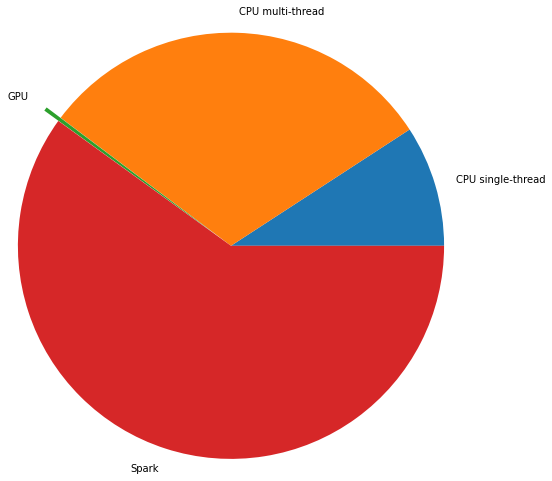

In [9]:
import matplotlib.pyplot as plt
import numpy as np

print("______________________CPU Single-Thread__________________________")
print("nejfrekventovanější slovo a počet jeho výskytů: '",most1[0],"':",most1[1])
print("nejméně frekventované slovo a počet jeho výskytů: '",least1[0],"':",least1[1])
print("celkový počet slov po filtracích: ",total1)
print("CPU čas: {0} ms".format(duration1/1000000))

print("______________________CPU Multi-Thread___________________________")
print("nejfrekventovanější slovo a počet jeho výskytů: '",most2[0],"':",most2[1])
print("nejméně frekventované slovo a počet jeho výskytů: '",least2[0],"':",least2[1])
print("celkový počet slov po filtracích: ",total2)
print("CPU čas: {0} ms".format(duration2/1000000))

print("_____________________________GPU_________________________________")
print("nejfrekventovanější slovo a počet jeho výskytů: '", most3[0], "':", most3[1])
print("nejméně frekventované slovo a počet jeho výskytů: '", least3[0], "':", least3[1])
print("celkový počet slov po filtracích: ",total3)
print("GPU čas: {0} ms".format(duration3/1000000))

print("____________________________SPARK________________________________")
print("nejfrekventovanější slovo a počet jeho výskytů: '", most4[0][0], "':", most4[0][1])
print("nejméně frekventované slovo a počet jeho výskytů: '",least4[0][0], "':", least4[0][1])
print("celkový počet slov po filtracích: ",total4)
print("SPARK čas: {0} ms".format(duration4/1000000))

total = duration1+duration2+duration3+duration4
y = np.array([duration1/total, duration2/total, duration3/total, duration4/total])
myexplode = [0, 0, 0.2, 0]
mylabels = ["CPU single-thread", "CPU multi-thread", "GPU", "Spark"]
plt.pie(y, labels = mylabels,  explode = myexplode, radius=2.45)
plt.show()